In [144]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
# from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import tensorflow as tf

In [145]:
train_dir = r"C:\Desktop\STUDY\PROJECTS\Project sem VI\archive (1)\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
test_dir = r"C:\Desktop\STUDY\PROJECTS\Project sem VI\archive (1)\Skin cancer ISIC The International Skin Imaging Collaboration\Test"

In [146]:
train_df = pd.DataFrame(columns=['image_path', 'label'])
test_df = pd.DataFrame(columns=['image_path', 'label'])

In [147]:
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_df = pd.concat([train_df, pd.DataFrame({'image_path': [image_path], 'label': [label]})], ignore_index=True)

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_df = pd.concat([test_df, pd.DataFrame({'image_path': [image_path], 'label': [label]})], ignore_index=True)


In [148]:
# Combine train_df and test_df into one dataframe
df = pd.concat([train_df, test_df], ignore_index=True)
del test_df,train_df
df

,image_path,label
0,C:\Desktop\STUDY\PROJECTS\Project sem VI\archi...,0
1,C:\Desktop\STUDY\PROJECTS\Project sem VI\archi...,0
2,C:\Desktop\STUDY\PROJECTS\Project sem VI\archi...,0
3,C:\Desktop\STUDY\PROJECTS\Project sem VI\archi...,0
4,C:\Desktop\STUDY\PROJECTS\Project sem VI\archi...,0
...,...,...
2352,C:\Desktop\STUDY\PROJECTS\Project sem VI\archi...,7
2353,C:\Desktop\STUDY\PROJECTS\Project sem VI\archi...,7
2354,C:\Desktop\STUDY\PROJECTS\Project sem VI\archi...,8
2355,C:\Desktop\STUDY\PROJECTS\Project sem VI\archi...,8


In [149]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'actinic keratosis',
 1: 'basal cell carcinoma',
 2: 'dermatofibroma',
 3: 'melanoma',
 4: 'nevus',
 5: 'pigmented benign keratosis',
 6: 'seborrheic keratosis',
 7: 'squamous cell carcinoma',
 8: 'vascular lesion'}

In [150]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

C:\Users\DEVADHARSHINI K\AppData\Local\Temp\ipykernel_3360\3886418994.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [151]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


In [152]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

8

In [153]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

In [154]:
df.head()

,image_path,label,image
0,C:\Desktop\STUDY\PROJECTS\Project sem VI\archi...,0,"[[[139, 79, 87], [138, 77, 84], [128, 63, 65],..."
1,C:\Desktop\STUDY\PROJECTS\Project sem VI\archi...,0,"[[[114, 85, 85], [96, 66, 60], [86, 64, 69], [..."
2,C:\Desktop\STUDY\PROJECTS\Project sem VI\archi...,0,"[[[166, 120, 116], [170, 126, 122], [175, 132,..."
3,C:\Desktop\STUDY\PROJECTS\Project sem VI\archi...,0,"[[[168, 91, 91], [179, 103, 102], [185, 112, 1..."
4,C:\Desktop\STUDY\PROJECTS\Project sem VI\archi...,0,"[[[206, 155, 156], [206, 156, 157], [211, 164,..."


In [155]:
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               basal cell carcinoma           392       
2               dermatofibroma                 111       
3               melanoma                       454       
4               nevus                          373       
5               pigmented benign keratosis     478       
6               seborrheic keratosis           80        
7               squamous cell carcinoma        197       
8               vascular lesion                142       
------------------------------------------------------------
Total                                         2357      


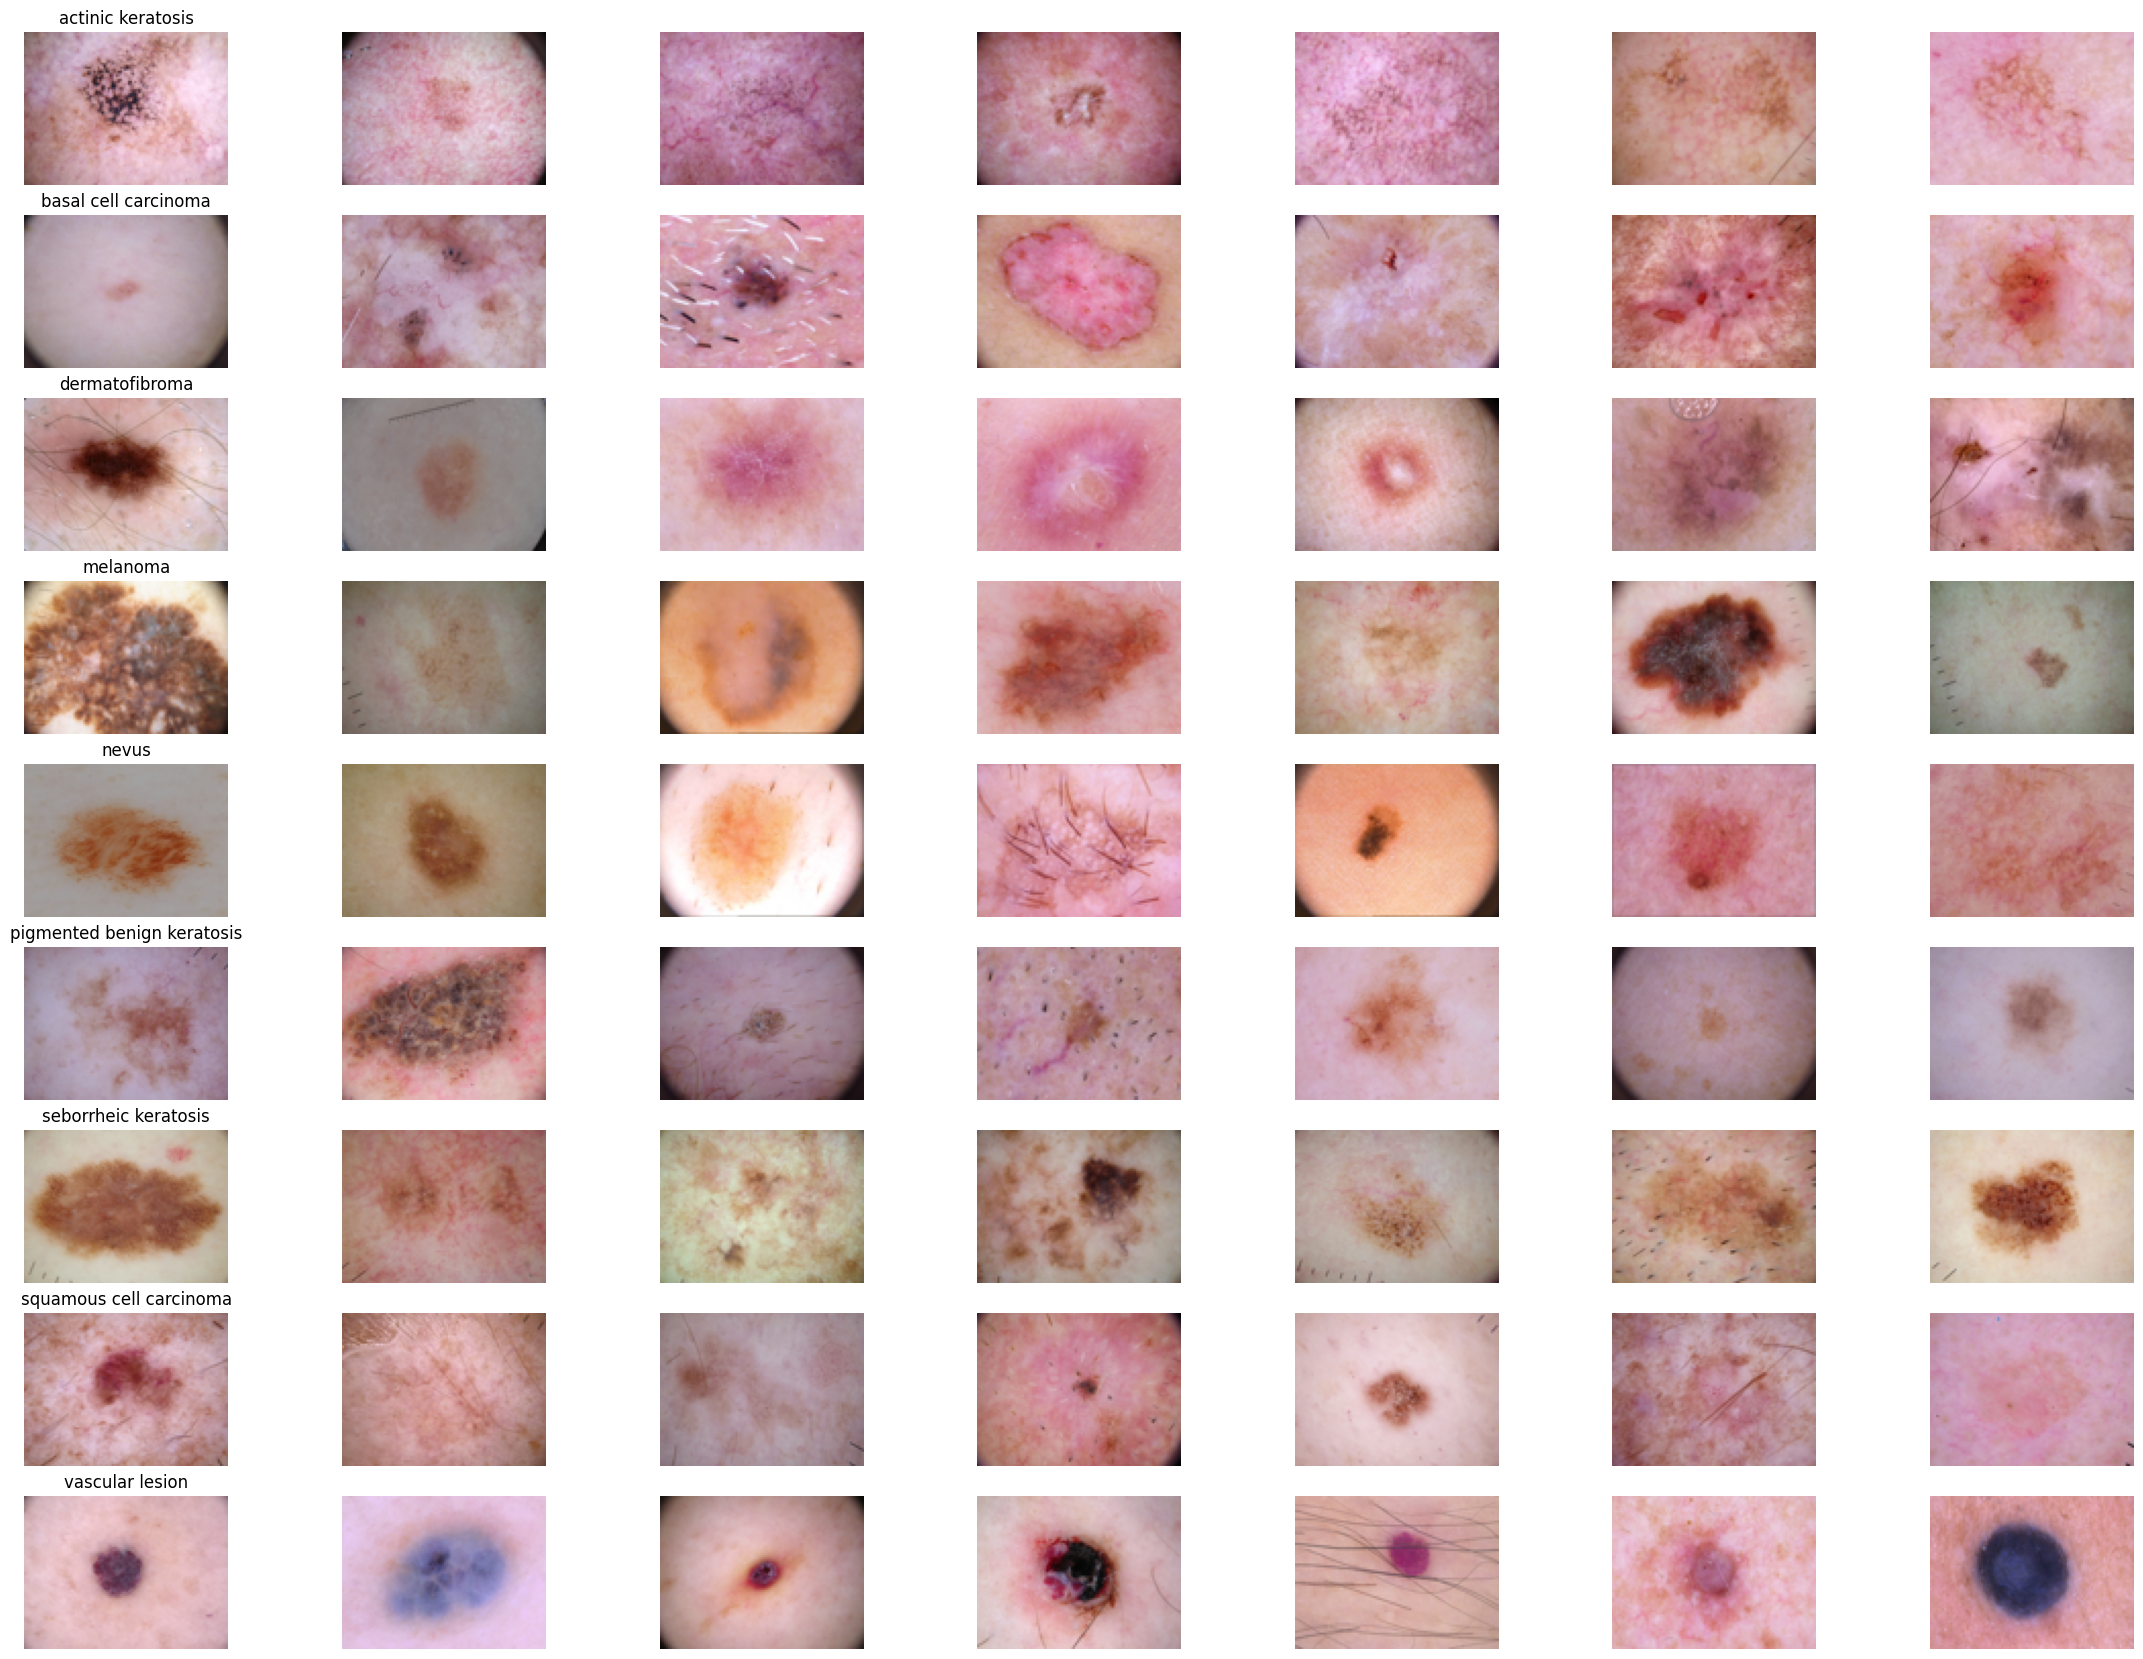

In [156]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [157]:
df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    2357
Name: count, dtype: int64

In [158]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,  # Increase rotation range
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,  # Increase shear intensity
    zoom_range=0.2,  # Increase zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

In [159]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']
print(target.shape,features.shape)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

(2357,) (2357, 1)


In [160]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [161]:
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

In [162]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.20,shuffle=True)
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [163]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load MobileNet model without the top layer (include_top=False) and specify input shape
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(75, 100, 3))

C:\Users\DEVADHARSHINI K\AppData\Local\Temp\ipykernel_3360\2524092375.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(75, 100, 3))


In [164]:
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Lambda, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

num_classes = len(label_map)  # This should match the actual number of classes in your dataset

# Input shape to match the shape of training data
input_cnn = Input(shape=(75, 100, 3), name='input_cnn')

def mobilenet_block(x, filters, kernel_size=(3, 3), strides=(1, 1)):
    x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)
    x = Conv2D(filters, kernel_size=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)
    return x


# Initial Conv2D layer
cnn_x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False)(input_cnn)
cnn_x = BatchNormalization()(cnn_x)
cnn_x = ReLU(6.)(cnn_x)

# MobileNet blocks
cnn_x = mobilenet_block(cnn_x, 64)
cnn_x = mobilenet_block(cnn_x, 128, strides=(2, 2))
cnn_x = mobilenet_block(cnn_x, 128)
cnn_x = mobilenet_block(cnn_x, 256, strides=(2, 2))
cnn_x = mobilenet_block(cnn_x, 256)
cnn_x = mobilenet_block(cnn_x, 512, strides=(2, 2))

# Flatten and Dense layers
cnn_x = GlobalAveragePooling2D()(base_model.output)
# cnn_x = GlobalAveragePooling2D()(cnn_x)
cnn_x = Dense(256, activation='relu')(cnn_x)
cnn_x = Dropout(0.5)(cnn_x)
cnn_output = Dense(num_classes, activation='softmax')(cnn_x)



In [165]:

# Define the model
combined_model = Model(inputs=base_model.input, outputs=cnn_output, name='combined_model')
# Model summary
combined_model.summary()

Model: "combined_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 75, 100, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 38, 50, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 38, 50, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 38, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 38, 50, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 38, 50, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 38, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 38, 50, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 38, 50, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 38, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 39, 51, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 19, 25, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 19, 25, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 19, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 19, 25, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 19, 25, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 19, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 19, 25, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 19, 25, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 19, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 19, 25, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,493,577 (13.33 MB)

 Trainable params: 3,471,689 (13.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [168]:
# Compile the model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [180]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model with learning rate scheduler
history = combined_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=epochs,
    steps_per_epoch=len(x_train) // 32,
    validation_data=(x_validate, y_validate),
    callbacks=[reduce_lr]
)


Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 47s 973ms/step - accuracy: 0.6930 - loss: 0.9501 - val_accuracy: 0.6207 - val_loss: 1.2593 - learning_rate: 0.0010
Epoch 2/25
 1/47 ━━━━━━━━━━━━━━━━━━━━ 41s 910ms/step - accuracy: 0.6250 - loss: 1.2271

C:\Users\DEVADHARSHINI K\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.6250 - loss: 1.2271 - val_accuracy: 0.6233 - val_loss: 1.2641 - learning_rate: 0.0010
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 963ms/step - accuracy: 0.7198 - loss: 0.8532 - val_accuracy: 0.5756 - val_loss: 1.5284 - learning_rate: 0.0010
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.6250 - loss: 0.9916 - val_accuracy: 0.5782 - val_loss: 1.5701 - learning_rate: 0.0010
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 961ms/step - accuracy: 0.6976 - loss: 0.8754 - val_accuracy: 0.6472 - val_loss: 1.1838 - learning_rate: 2.0000e-04
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.7500 - loss: 0.6268 - val_accuracy: 0.6472 - val_loss: 1.1820 - learning_rate: 2.0000e-04
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 952ms/step - accuracy: 0.7604 - loss: 0.7050 - val_accuracy: 0.6472 - val_loss: 1.1206 - learning_rate: 2.0000e-04
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5625 - loss: 1.5218 - 

In [181]:
loss, accuracy = combined_model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - accuracy: 0.6773 - loss: 1.0216
Test: accuracy = 0.707627  ;  loss = 0.892187


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = combined_model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [ ]:
def predict_single(model, x_random, y_random, label_map):
    predictions = model.predict(x_random)
    for i in range(len(x_random)):
        print(f"Actual: {label_map[np.argmax(y_random[i])]}")
        print(f"Predicted: {label_map[np.argmax(predictions[i])]}")
        print()
import random

random_indices = random.sample(range(len(x_test)), 5)
x_random = x_test[random_indices]
y_random = y_test[random_indices]

print("New Network")
predict_single(combined_model, x_random, y_random, label_map)

In [ ]:
from keras.models import load_model
combined_model.save('newnetwork.h5')